In [1]:
import duckdb
import pandas as pd

con = duckdb.connect()

# input_file = 'testdata.csv'
input_file = 'data/orders.csv'

df = con.query(f"""
    select *
    from read_csv('{input_file}', names=['id', 'party', 'price', 'quantity', 'timestamp', 'side'])
""").df()
df

,id,party,price,quantity,timestamp,side
0,70000001,Mal,73.21,100,100001,BUY
1,70000002,Wash,76.56,200,100016,SELL
2,70000003,Mal,85.04,100,100075,BUY
3,70000004,Simon,72.54,100,100137,BUY
4,70000005,River,57.48,600,100142,BUY
...,...,...,...,...,...,...
9995,70009996,Wash,80.80,200,603795,SELL
9996,70009997,Kaylee,80.36,100,603808,BUY
9997,70009998,Simon,63.06,100,603840,BUY
9998,70009999,Shepherd,98.55,200,603849,SELL


In [2]:
res = con.query("""
    select distinct price as test_price
    from df
    where price <= (
            select max(price) from df where side='BUY'
        ) and price >= (
            select min(price) from df where side='SELL'
        )
    order by price desc
""").df()
res

,test_price
0,98.77
1,98.66
2,98.55
3,98.44
4,98.33
...,...
417,52.23
418,52.12
419,52.01
420,51.90


In [3]:
transaction_info_list = []
for test_price in res['test_price']:
    transaction_info = con.query(f"""
        with cte1 as (
            select sum(quantity) as Q_A_p
            from df
            where side='SELL' and price <= {test_price}
        ), cte2 as (
            select sum(quantity) as Q_B_p
            from df
            where side='BUY' and price >= {test_price}
        )
        select Q_A_p, Q_B_p, {test_price} * least(Q_A_p, Q_B_p) as transaction_amount
        from cte1, cte2
    """).df()
    transaction_info_list.append(transaction_info)

transaction_info_list = pd.concat(transaction_info_list, ignore_index=True)
res = pd.concat([res, transaction_info_list], axis=1)
print("row with max transaction_amount: ")
print(res.loc[res['transaction_amount'].idxmax()])
res

row with max transaction_amount: 
test_price                 75.33
Q_A_p                  126868.00
Q_B_p                  125451.00
transaction_amount    9450223.83
Name: 210, dtype: float64


,test_price,Q_A_p,Q_B_p,transaction_amount
0,98.77,1130177.0,400.0,39508.0
1,98.66,1125668.0,400.0,39464.0
2,98.55,1120868.0,400.0,39420.0
3,98.44,1113752.0,400.0,39376.0
4,98.33,1108752.0,400.0,39332.0
...,...,...,...,...
417,52.23,200.0,1110149.0,10446.0
418,52.12,200.0,1113710.0,10424.0
419,52.01,200.0,1119110.0,10402.0
420,51.90,200.0,1124010.0,10380.0


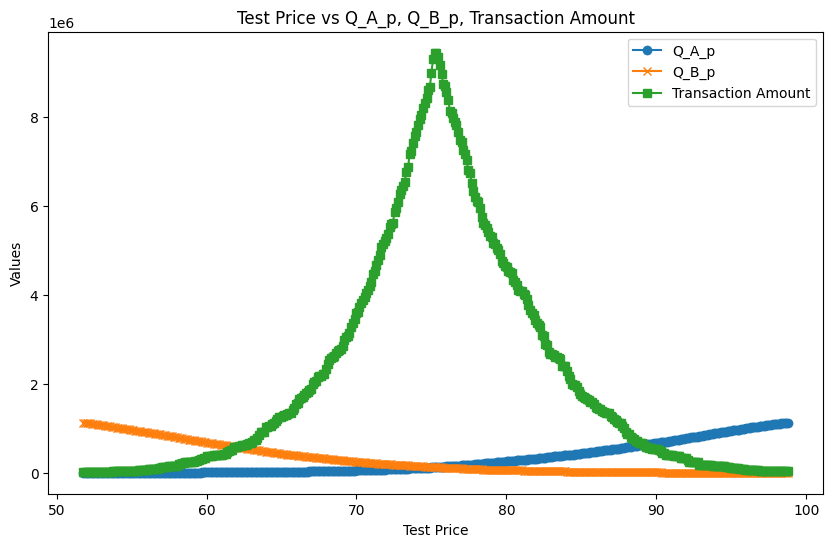

In [4]:
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))

# plot Q_A_p
plt.plot(res['test_price'], res['Q_A_p'], label='Q_A_p', marker='o')

# plot Q_B_p
plt.plot(res['test_price'], res['Q_B_p'], label='Q_B_p', marker='x')

# plot transaction_amount
plt.plot(res['test_price'], res['transaction_amount'], label='Transaction Amount', marker='s')

# add labels and title
plt.xlabel('Test Price')
plt.ylabel('Values')
plt.title('Test Price vs Q_A_p, Q_B_p, Transaction Amount')

# add legend
plt.legend()

# display the plot
plt.show()